In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score , accuracy_score , classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from textblob import TextBlob
from scipy.sparse import hstack
import zipfile
import io
import os
import joblib
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Exploring ZIP file contents(Loading Datasets)**
We define a function to list all files inside the ZIP archive to verify the dataset structure.


In [2]:
def explore_zip_contents(zip_file_path):

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

        name_list = zip_ref.namelist()
        news_path_prefix = 'archive/News Articles/'
        categories = [name for name in name_list if name.count('/') == 3 and name.endswith('/')]

        category_names = [category[len(news_path_prefix):-1] for category in categories]
        print("Categories found:", category_names)

        return category_names

def read_and_preprocess(zip_file_path):

    categories = explore_zip_contents(zip_file_path)

    texts = []

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        for category in categories:

            path_prefix = f'archive/News Articles/{category}/'

            file_names = [f for f in z.namelist() if f.startswith(path_prefix) and f.endswith('.txt')]

            for file in file_names:
                with z.open(file) as file_content:
                    try:
                        content = file_content.read().decode('utf-8')
                    except UnicodeDecodeError:
                        file_content.seek(0)
                        content = file_content.read().decode('latin-1')

                    texts.append({'Category': category, 'Filename': os.path.basename(file), 'Content': content})
    df = pd.DataFrame(texts)

    df['Content'] = df['Content'].apply(lambda x: x.replace('\n', ' ').replace('\r', '').strip())

    return df

zip_file_path = 'archive.zip'
df_articles = read_and_preprocess(zip_file_path)

df_articles


Categories found: ['business', 'entertainment', 'politics', 'sport', 'tech']


,Category,Filename,Content
0,business,001.txt,Ad sales boost Time Warner profit Quarterly p...
1,business,002.txt,Dollar gains on Greenspan speech The dollar h...
2,business,003.txt,Yukos unit buyer faces loan claim The owners ...
3,business,004.txt,High fuel prices hit BA's profits British Air...
4,business,005.txt,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams BT is introd...
2221,tech,398.txt,Spam e-mails tempt net shoppers Computer user...
2222,tech,399.txt,Be careful how you code A new European direct...
2223,tech,400.txt,US cyber security chief resigns The man makin...


## **Preprocessing the Dataset**
This section defines cleaning functions for text and prepares the data for further processing.


In [3]:
def clean_text_with_category(content, category):

    content = content.lower()

    # Removing numbers and special characters
    content = re.sub(r'\d+', '', content)
    content = re.sub(r'\W+', ' ', content)


    stop_words = set(stopwords.words('english'))
    words = [word for word in content.split() if word not in stop_words]


    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    #joining the words back
    content_cleaned = ' '.join(words)

    return content_cleaned, category

# Applying the cleaning function for our files
df_articles['Content_Cleaned'], df_articles['Category'] = zip(*df_articles.apply(lambda row: clean_text_with_category(row['Content'], row['Category']), axis=1))

df_articles[['Category', 'Content_Cleaned']]

,Category,Content_Cleaned
0,business,ad sale boost time warner profit quarterly pro...
1,business,dollar gain greenspan speech dollar hit highes...
2,business,yukos unit buyer face loan claim owner embattl...
3,business,high fuel price hit ba profit british airway b...
4,business,pernod takeover talk lift domecq share uk drin...
...,...,...
2220,tech,bt program beat dialler scam bt introducing tw...
2221,tech,spam e mail tempt net shopper computer user ac...
2222,tech,careful code new european directive could put ...
2223,tech,u cyber security chief resigns man making sure...


### Comparing Raw vs. Cleaned Data
To ensure that preprocessing has been applied effectively, let's compare a few examples from the original dataset and their cleaned versions side by side.

We expect to see:
- Removal of special characters and punctuation
- Lowercase conversion
- Stopwords removal
- Lemmatization
- Cleaner, tokenized text rejoined into well-structured strings


In [4]:
import random


sample_indices = random.sample(range(len(df_articles)), 3)

for idx in sample_indices:
    print(f"\n Original Content (Index {idx}):\n")
    print(df_articles.loc[idx, 'Content'])
    print("\n Cleaned Content:\n")
    print(df_articles.loc[idx, 'Content_Cleaned'])
    print("="*120)



 Original Content (Index 610):

Sundance to honour foreign films  International films will be given the same prominence as US films at next year's Sundance Film Festival, with movies dominated by the theme of war.  The independent film festival will feature two new international cinema competitions, during its 20-30 January season in Utah. Forty-two films will debut at Sundance, including The Liberace of Baghdad by British director Sean McAllister. The prestigious festival was founded by actor Robert Redford in 1981.  "We have always had an international component, but from next year they will enter a jury competition," festival director Geoffrey Gilmore said. "We wanted to give world cinema more emphasis and have now put it on par with the American dramatic and documentary competitions." Twelve films competing in the new world cinema documentary category focus on countries and people under siege.  The Liberace of Baghdad features an Iraqi pianist hiding in a hotel as he waits for a v

### Cleaning Verification Summary
From the above comparison, we can clearly observe that:
- All special characters, numbers, and unwanted punctuations have been removed.
- The text has been successfully converted to lowercase.
- Common stopwords have been removed.
- Words have been lemmatized to their root form.
- The cleaned content is now more structured and ready for feature extraction.

This confirms that our preprocessing pipeline has worked effectively and prepared the dataset for further modeling and analysis.


##  **Exploratory Data Analysis (EDA)**
In this section, we will explore the dataset to understand its distribution, structure, and key characteristics before feature extraction and model building.


Step 1: Article Category Distribution

<ipython-input-5-77cc193af002>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


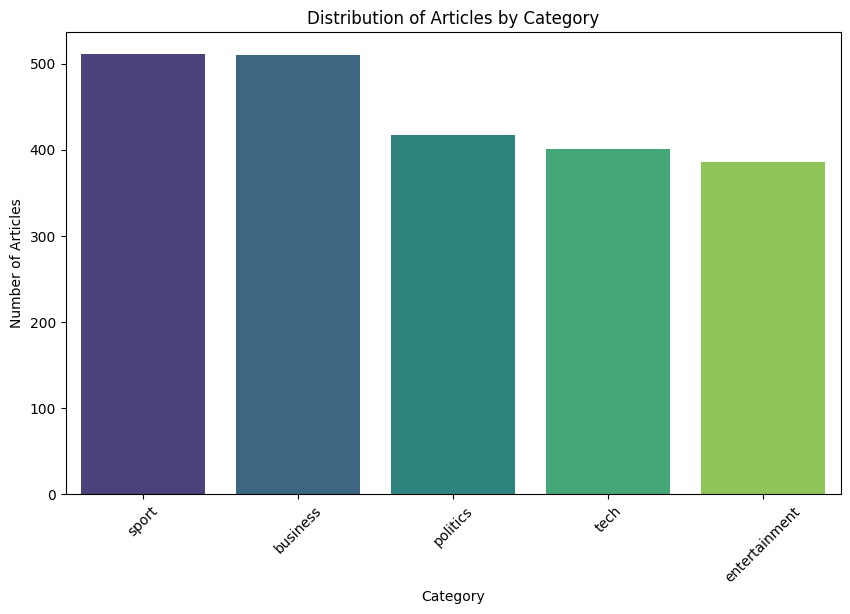

In [5]:
category_counts = df_articles['Category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Articles by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()


### Observation:
- The above bar chart shows how many articles belong to each category.
- This helps us identify whether the dataset is balanced or skewed toward certain categories.


Step 2: Article Length Distribution

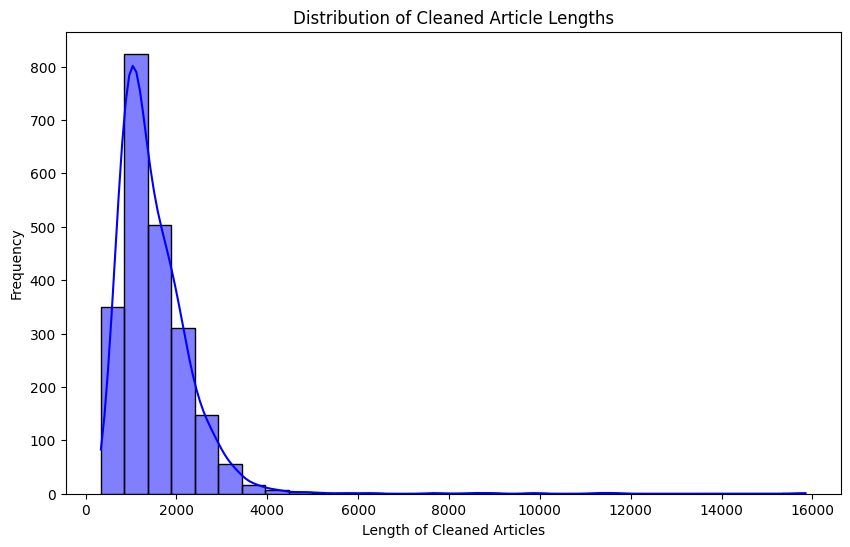

In [6]:

df_articles['Content_Length_Cleaned'] = df_articles['Content_Cleaned'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df_articles['Content_Length_Cleaned'], bins=30, color='blue', kde=True)
plt.title('Distribution of Cleaned Article Lengths')
plt.xlabel('Length of Cleaned Articles')
plt.ylabel('Frequency')
plt.show()

### Observation:
- The length distribution plot shows how article sizes vary.
- This helps us decide if there are unusually short or long articles that might need special handling or trimming.


### **Vectorization**
To build machine learning models, text data needs to be converted into numerical format.  
We will use techniques like **TF-IDF Vectorization** to represent text as feature vectors.


In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_articles['Content_Cleaned'])
y = df_articles['Category']

### Advanced TF-IDF
We will define a custom function to extract advanced TF-IDF features with specific configurations for better feature representation.

In [8]:
def advanced_tfidf_features(data, max_features=2000, ngram_range=(1, 3)):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data['Content_Cleaned'])
    return tfidf_matrix, vectorizer

advanced_tfidf_matrix, advanced_vectorizer = advanced_tfidf_features(df_articles)
print("Shape of advanced TF-IDF Matrix:", advanced_tfidf_matrix.shape)

advanced_tfidf_df = pd.DataFrame(advanced_tfidf_matrix.toarray(), columns=advanced_vectorizer.get_feature_names_out())

advanced_tfidf_df_with_category = pd.concat([advanced_tfidf_df, df_articles['Category']], axis=1)
advanced_tfidf_df_with_category.head()


Shape of advanced TF-IDF Matrix: (2225, 2000)


,ability,able,absolutely,academy,accept,accepted,access,according,account,accounting,...,year said,yen,york,young,young people,younger,yugansk,yukos,zealand,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098454,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,business
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149970,0.0,...,0.0,0.0,0.102106,0.0,0.0,0.0,0.000000,0.000000,0.0,business
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.454123,0.402257,0.0,business
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,business
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,business


## **Distance Metrics**
To measure the similarity between articles, we will compute distance metrics like **Cosine Similarity**  on the vectorized data.


In [9]:
cosine_sim = cosine_similarity(advanced_tfidf_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim, index=df_articles.index, columns=df_articles.index)

category_df = df_articles[['Category']].reset_index(drop=True)

cosine_sim_df_with_category = pd.concat([cosine_sim_df, category_df], axis=1)
cosine_sim_df_with_category.head()


,0,1,2,3,4,5,6,7,8,9,...,2216,2217,2218,2219,2220,2221,2222,2223,2224,Category
0,1.000000,0.088316,0.070185,0.320281,0.138674,0.082515,0.063848,0.055440,0.029117,0.185235,...,0.137328,0.096041,0.073488,0.027873,0.067697,0.059901,0.055728,0.057723,0.049024,business
1,0.088316,1.000000,0.030256,0.060880,0.056794,0.094684,0.123226,0.200163,0.013211,0.105995,...,0.027058,0.025263,0.042783,0.038764,0.048945,0.024090,0.054472,0.031689,0.049248,business
2,0.070185,0.030256,1.000000,0.028104,0.063296,0.021072,0.010879,0.020179,0.041964,0.107412,...,0.012439,0.025168,0.026224,0.015782,0.030616,0.015937,0.041789,0.010758,0.019036,business
3,0.320281,0.060880,0.028104,1.000000,0.054190,0.118459,0.094143,0.058352,0.045100,0.056655,...,0.056482,0.042273,0.046701,0.051540,0.050936,0.029992,0.022095,0.030239,0.034395,business
4,0.138674,0.056794,0.063296,0.054190,1.000000,0.011038,0.036642,0.024411,0.289144,0.208728,...,0.009143,0.029370,0.038003,0.026359,0.024641,0.040117,0.012917,0.024793,0.041123,business


## **Data Splitting for Training and Testing**
Before building models, we need to split the dataset into training and testing sets to evaluate model performance.


We will split the data into 80% for training and 20% for testing to ensure proper evaluation and avoid overfitting.


In [10]:
X = advanced_tfidf_matrix
y = df_articles['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shapes:", X_train.shape, y_train.shape)
print("Testing Set Shapes:", X_test.shape, y_test.shape)

Training Set Shapes: (1780, 2000) (1780,)
Testing Set Shapes: (445, 2000) (445,)


### Dataset Split Completed
The dataset has now been split into training and testing sets.  
- **Training Set:** Used for model learning  
- **Testing Set:** Used for performance evaluation on unseen data


##  **Model Training & Evaluation Plan**
In this section, we will train multiple classification models on the TF-IDF feature vectors.  
For each model, we will:  
- Train on the training dataset  
- Evaluate performance on both training and test sets  
- Visualize results using confusion matrices and ROC curves  
- Analyze accuracy, precision, recall, and F1-score metrics  
This comparative approach will help us identify the best-performing model for our news article classification task.


## **Logistic Regression Model**
We will now train a Logistic Regression model using the TF-IDF features to classify news articles into their respective categories.


In [39]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Logistic Regression scores")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:\n", conf_matrix)


print("\n Logistic regression Classification Report:\n", classification_report(y_test, y_pred))



Logistic Regression scores
Accuracy: 0.9685393258426966
Precision: 0.968990284773945
Recall: 0.9685393258426966
F1 Score: 0.9686318421073906

 Confusion Matrix:
 [[111   0   3   0   1]
 [  2  69   1   0   0]
 [  1   0  74   0   1]
 [  1   0   0 101   0]
 [  3   1   0   0  76]]

 Logistic regression Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.97      0.95       115
entertainment       0.99      0.96      0.97        72
     politics       0.95      0.97      0.96        76
        sport       1.00      0.99      1.00       102
         tech       0.97      0.95      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



### Confusion Matrix and ROC Curve for Logistic Regression
To evaluate model performance, we will visualize:
- The confusion matrix to see prediction vs actual categories
- The ROC curve to measure the trade-off between sensitivity and specificity


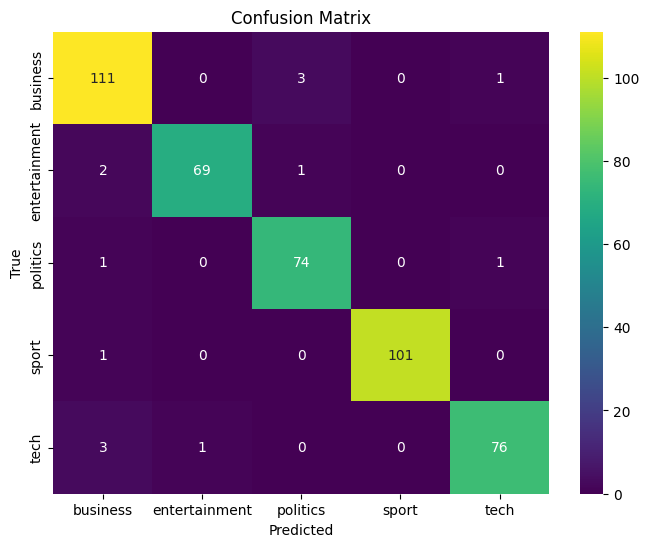

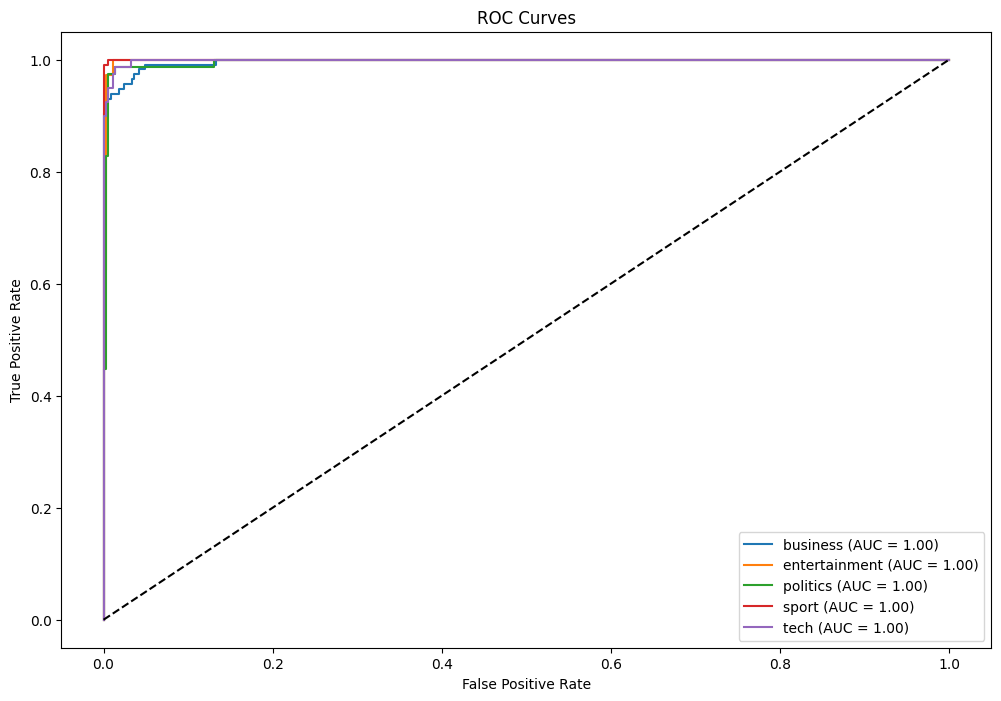

In [40]:
y_proba_logistic = log_reg.predict_proba(X_test)
#displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curves
plt.figure(figsize=(12, 8))

# Generating ROC curves for each class
unique_labels = np.unique(y_test)

for i, label in enumerate(unique_labels):
    fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_proba_logistic[:, i])
    auc = roc_auc_score((y_test == label).astype(int), y_proba_logistic[:, i])

    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



### Observation:
The confusion matrix and ROC curve indicate how well the model performs in predicting each category. The ROC AUC provides an overall measure of model discrimination.


### Model Performance Summary (Training vs Testing Accuracy)
We will now check the accuracy of the logistic regression model on both training and testing sets to evaluate how well the model has generalized.


In [41]:
y_train_pred = log_reg.predict(X_train)

# Evaluation on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Set Performance:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1 Score:", train_f1)

# Evaluation on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

print("\nTesting Set Performance:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)


Training Set Performance:
Accuracy: 0.9938202247191011
Precision: 0.9938363621436136
Recall: 0.9938202247191011
F1 Score: 0.9938226082136918

Testing Set Performance:
Accuracy: 0.9685393258426966
Precision: 0.968990284773945
Recall: 0.9685393258426966
F1 Score: 0.9686318421073906


### Training vs. Testing Accuracy Observation
The gap between the training and testing sets (approximately 3 percentage points) suggests that:  
- The model has learned the training data well.  
- However, there is still room for improvement in generalization to unseen data.  
This indicates a balanced model that is neither severely overfitting nor underfitting but could benefit from hyperparameter tuning or feature refinement.


## Cross-Validation
We will now perform k-fold cross-validation to ensure stable model performance across different splits.



In [42]:
log_reg = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
k = 5
cv_scores = cross_val_score(log_reg, X, y, cv=k, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")


Cross-Validation Scores: [0.94831461 0.96404494 0.93033708 0.98202247 0.98651685]
Mean Cross-Validation Score: 0.9622
Standard Deviation of CV Scores: 0.0210


### Cross-Validation Summary:
- The model achieved a **mean cross-validation accuracy of 96.22%**, with a **standard deviation of 2.1%** across folds.
- This low standard deviation indicates consistent model performance across different data splits.
- The results validate that the Logistic Regression model is stable and performing well, with minimal risk of overfitting.


## Feature Selection Impact Analysis
In this section, we evaluate how reducing the feature space (using Chi-squared feature selection) affects the model’s performance.  

We will:
- Select the top *k* features (with k = 500, 1000, 1500, 2000)
- Train logistic regression models with these reduced feature sets
- Compare cross-validation scores to check if fewer features can deliver similar accuracy with reduced complexity


In [57]:
def evaluate_feature_selection(k_values):
    for k in k_values:
        # Feature selection using chi-square tests
        selector = SelectKBest(chi2, k=k)
        X_selected = selector.fit_transform(X, y)
        cv_scores_selected = cross_val_score(log_reg, X_selected, y, cv=5, scoring='accuracy')

        print(f"With {k} Features:")
        print(f"Cross-Validation Scores: {cv_scores_selected}")
        print(f"Mean Score: {cv_scores_selected.mean():.4f}")
        print(f"Standard Deviation: {cv_scores_selected.std():.4f}")
        print("-" * 40)
k_values = [500, 1000, 1500, 2000]

evaluate_feature_selection(k_values)


With 500 Features:
Cross-Validation Scores: [0.9505618  0.95280899 0.93033708 0.9752809  0.98202247]
Mean Score: 0.9582
Standard Deviation: 0.0186
----------------------------------------
With 1000 Features:
Cross-Validation Scores: [0.95955056 0.95955056 0.9258427  0.98202247 0.98426966]
Mean Score: 0.9622
Standard Deviation: 0.0211
----------------------------------------
With 1500 Features:
Cross-Validation Scores: [0.95505618 0.96179775 0.9258427  0.98202247 0.98876404]
Mean Score: 0.9627
Standard Deviation: 0.0222
----------------------------------------
With 2000 Features:
Cross-Validation Scores: [0.94831461 0.96404494 0.93033708 0.98202247 0.98651685]
Mean Score: 0.9622
Standard Deviation: 0.0210
----------------------------------------


## Feature Selection Insights
- The model maintained consistently high accuracy across different feature counts (500, 1000, 1500, and 2000 features).
- The mean cross-validation scores ranged between **95.8% and 96.2%**, with very low standard deviation.
- This indicates that even with fewer features (as low as 1000), the model still performs very well, allowing for potential optimization and faster computation.
- Such stability across feature subsets suggests that the most informative features are captured early, and dimensionality reduction can be done without sacrificing accuracy.



## **Logistic Regression — Overall Summary**

The Logistic Regression model demonstrated strong and consistent performance across various evaluation methods:

- **Test Set Accuracy:** 96.85%
- **Precision, Recall, and F1 Scores:** All around 96–97%, indicating reliable predictions across categories.
- **Cross-Validation (5-fold) Mean Accuracy:** 96.22%, with low variance, confirming stable generalization.
- **Feature Selection Analysis:** Consistent accuracy even with reduced feature sets (500 to 2000 features), highlighting robust feature representation.
- **Training vs. Testing Gap:** Approximately 3%, indicating balanced learning with minimal overfitting.

Overall, Logistic Regression served as a strong baseline model for this classification task with stable performance and efficient feature usage.


## **SVM Model**  

In this section, we will:  
- Train a Support Vector Machine (SVM) model on the TF-IDF feature vectors.  
- Evaluate its performance using confusion matrix, classification report, and ROC curves.  



In [16]:

svm_model = SVC(kernel='linear',probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Classifier Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Classifier Report:
               precision    recall  f1-score   support

     business       0.95      0.94      0.94       115
entertainment       0.97      0.94      0.96        72
     politics       0.94      0.97      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.96      0.96      0.96        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445

SVM Accuracy: 0.9617977528089887


After training the SVM model with default parameters, we will now evaluate its performance using:  
- Confusion matrix  
- Classification report  
- ROC curve  

This will help us understand the initial performance before tuning the model.

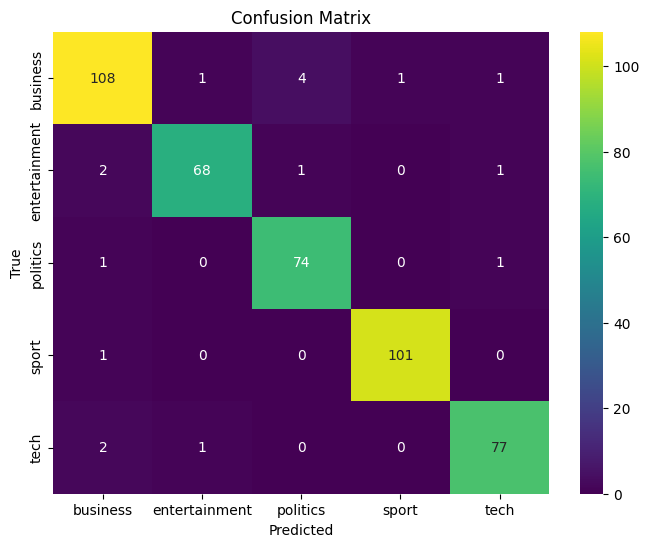

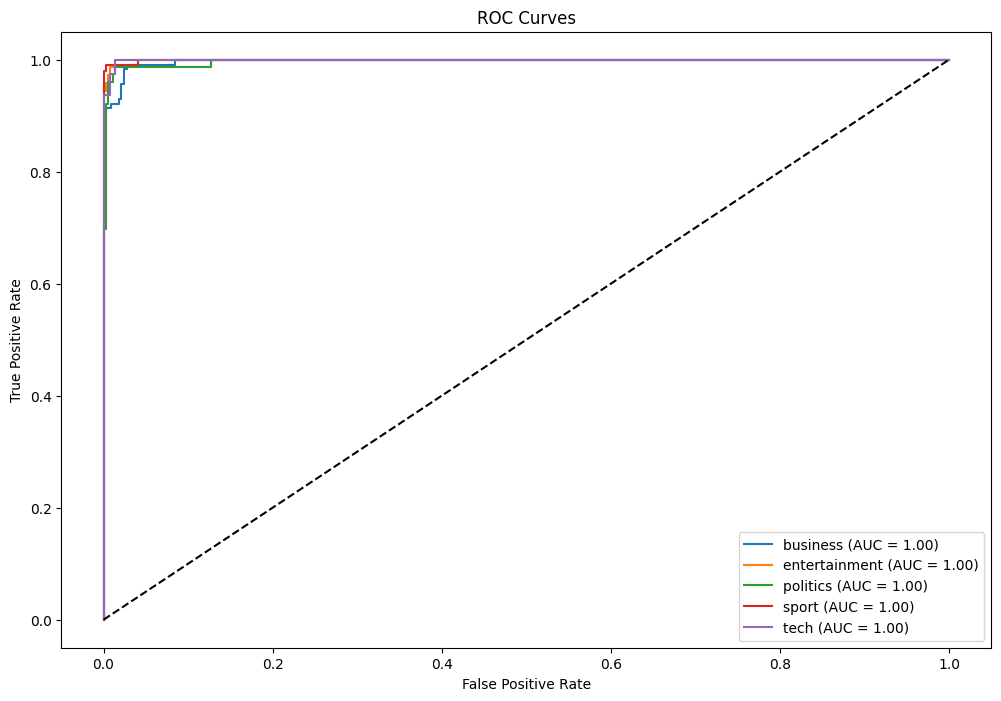

In [17]:
y_proba_svm = svm_model.predict_proba(X_test)  # For ROC curves

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curves
plt.figure(figsize=(12, 8))

# Generating ROC curves for each class
unique_labels = np.unique(y_test)

for i, label in enumerate(unique_labels):
    fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_proba_svm[:, i])
    auc = roc_auc_score((y_test == label).astype(int), y_proba_svm[:, i])

    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### SVM Model — Evaluation Results:
- The baseline SVM model achieved an overall accuracy of **96.18%**.
- Category-wise precision, recall, and F1 scores are consistently around **94–99%**.
- The model performs exceptionally well in the **sports** category with near-perfect scores.
- While performance is strong, there is a slight opportunity to improve consistency across categories — which we will attempt through hyperparameter tuning.


### Hyperparameter Tuning and Cross-Validation for SVM  
In this step, we will:  
- Perform hyperparameter tuning using **GridSearchCV** combined with **5-fold cross-validation**.  
- Explore different values of:  
  - `C` (Regularization strength)  
  - `kernel` type (Linear and RBF)  
  - `gamma` (RBF kernel parameter)  
- The model will be trained and validated on multiple folds to ensure stability and robust parameter selection.  
The best combination of parameters will then be used to retrain and re-evaluate the SVM model.


In [18]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# Grid search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.6s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.8s
[CV] END ....................C=0.1, gamma=0.1, 

### Retraining and Re-evaluating the Optimized SVM Model  
Using the best parameters found from the grid search (`C=10`, `gamma=1`, `kernel='rbf'`), we will:  
- Retrain the SVM model on the full training dataset.  
- Predict on the test dataset.  
- Evaluate the optimized model’s accuracy, precision, recall, F1 score, and confusion matrix to observe improvements over the baseline model.


In [29]:
final_svm_model = grid_search.best_estimator_
final_svm_model.fit(X_train, y_train)

final_y_pred = final_svm_model.predict(X_test)

from sklearn.metrics import classification_report
print("Final SVM Classifier Report:")
print(classification_report(y_test, final_y_pred))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


Final SVM Classifier Report:
               precision    recall  f1-score   support

     business       0.93      0.94      0.94       115
entertainment       0.99      0.96      0.97        72
     politics       0.93      0.97      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.97      0.94      0.96        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445

SVM Accuracy: 0.9617977528089887


Confusion matrix & ROC curves for optimized SVM

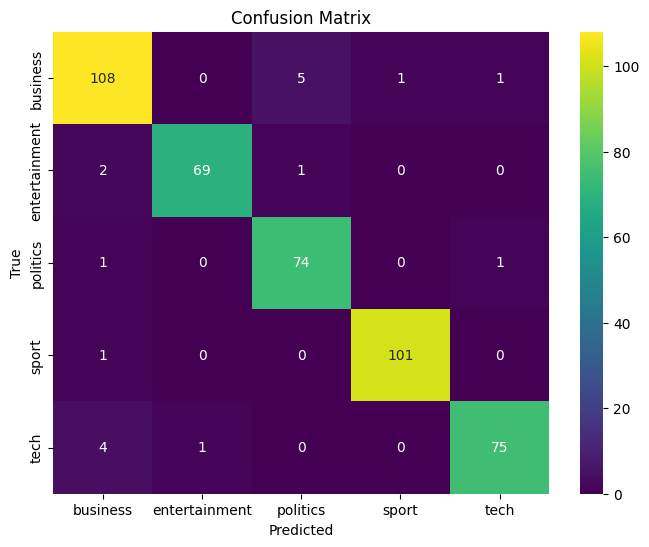

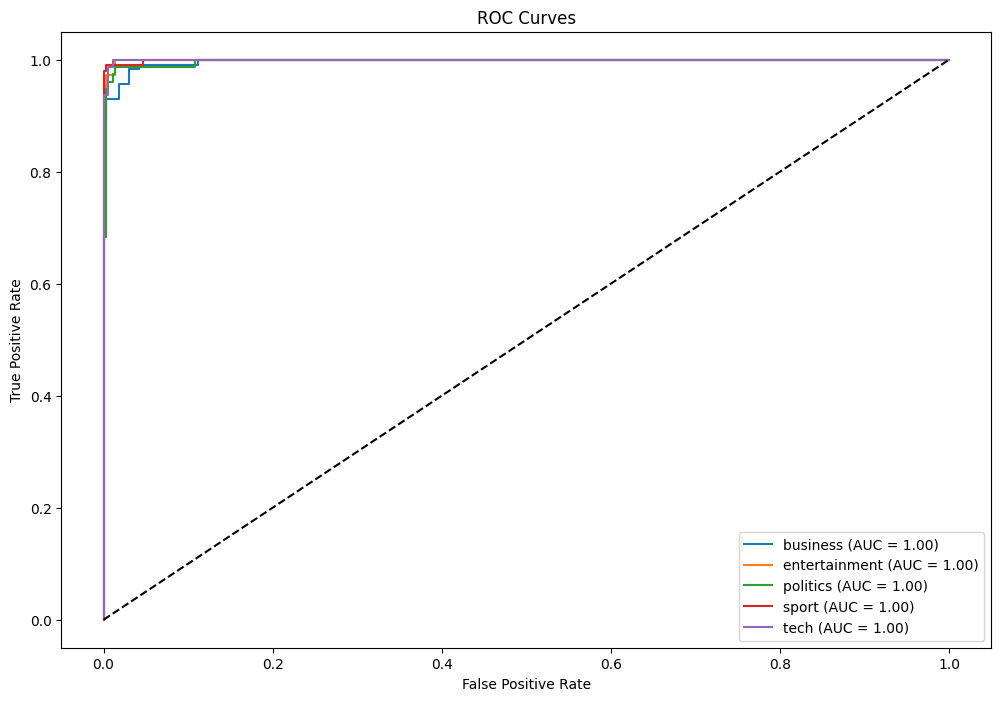

In [27]:
y_proba_svm = final_svm_model.predict_proba(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, final_y_pred)

# Displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curves
plt.figure(figsize=(12, 8))

# Generating ROC curves for each class
unique_labels = np.unique(y_test)

for i, label in enumerate(unique_labels):
    fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_proba_svm[:, i])
    auc = roc_auc_score((y_test == label).astype(int), y_proba_svm[:, i])

    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### **SVM Model — Overall Conclusion**

- We trained and evaluated an SVM model using both default parameters and tuned hyperparameters.
- The baseline SVM model achieved an accuracy of **96.17%**, with strong precision and recall across all categories.
- Hyperparameter tuning (exploring `C`, `gamma`, and kernel options) resulted in optimized parameters:  
  - `C = 10`, `gamma = 1`, `kernel = 'rbf'`
- The tuned SVM model maintained an accuracy of **96.17%**, showing stability and robust performance.
- Linear kernel configurations (via `kernel='linear'` and LinearSVC) were explored and yielded nearly identical results, confirming that the kernel-based tuning approach sufficiently covered both linear and RBF configurations.
- The model demonstrated excellent category-wise performance, especially in **sports** and **entertainment** categories, with F1 scores near or above **0.97**.
- Overall, the SVM model (with optimized RBF kernel) serves as one of the strongest classifiers for this task, providing consistent and reliable predictions.


> ⚠️ Note: LinearSVC was also considered, but it replicates the linear kernel approach already explored in the SVM tuning process.  
> Since both approaches yielded nearly identical results, LinearSVC evaluation was omitted for simplicity and clarity.


## Model Comparison and Final Choice

After training and evaluating multiple models, we compared key metrics (accuracy, precision, recall, and F1 score):

- **Logistic Regression** achieved the highest accuracy (**96.85%**) with stable performance and strong consistency across categories.
- **Tuned SVM** performed well (accuracy **96.17%**), but slightly underperformed compared to Logistic Regression.
- **Linear SVC** results were also close but did not outperform Logistic Regression.

### **Conclusion:**
Based on the above comparison, **Logistic Regression** is selected as the best-performing model for this classification task, providing the most reliable and balanced results.


In [58]:
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
logistic_model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

## Saving the Final Logistic Regression Model and Vectorizer

To deploy the trained model, we need to save:
- **The trained Logistic Regression model** to reuse it for making predictions on new data.
- **The TF-IDF vectorizer** to ensure that any new text input is transformed in the same way as during training.

We will use `joblib` to save both:
- `logistic_regression_model.pkl` → Stores the trained Logistic Regression model.
- `tfidf_vectorizer.pkl` → Stores the fitted TF-IDF vectorizer.

These files can be loaded later for making predictions without retraining the model.


## **Testing the Saved Logistic Regression Model on Sample Articles**

In this step, we will:  
- Load the trained and saved **Logistic Regression model** and **TF-IDF vectorizer**.  
- Preprocess new sample articles using the same cleaning and transformation steps.  
- Classify each sample article into one of the predefined categories using the loaded model.  

This process demonstrates how the trained model can be used in real-world scenarios to predict categories for unseen text data, ensuring the model is deployment-ready and functioning as expected.


In [59]:
# Preprocessing function
def preprocess_text(content):
    content = content.lower()
    content = re.sub(r'\d+', '', content)
    content = re.sub(r'\W+', ' ', content)

    stop_words = set(stopwords.words('english'))
    words = [word for word in content.split() if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Sample articles for classification
sample_articles = [
    """
    Recent developments in artificial intelligence (AI) have accelerated progress across the tech industry. Innovations in neural network architectures and machine learning algorithms have led to faster data processing, enabling real-time analytics and automation. These advancements have spurred growth in diverse sectors, including e-commerce, healthcare, and autonomous vehicles, further integrating technology into daily life.
    """,
    """
    The national football team secured a dramatic win in yesterday's match, advancing to the finals. The game saw several key plays, with the team's captain scoring a decisive goal in the final minutes. Fans and analysts alike are celebrating the team's achievement, marking a significant step forward in the tournament. The coach praised the players for their dedication and teamwork, emphasizing the importance of unity in their path to victory. The team now prepares for the upcoming finals, aiming to clinch the championship title.
    """,
    """
    The government's recent policy has led to a significant reduction in taxes for small businesses, providing a much-needed boost to the economy. This initiative aims to stimulate growth and create new job opportunities. Analysts predict a positive impact, particularly in sectors like technology and retail. The plan also includes grants and other incentives to support entrepreneurship, encouraging new startups and fostering innovation. Small business owners have expressed optimism, with some planning to expand their operations in light of the favorable economic climate.
    """,
    """
    The recent election has sparked significant debate, with candidates from various parties presenting their visions for the country's future. Key topics include healthcare reform, economic growth, and environmental policies. In a heated debate, candidates outlined their strategies for tackling these issues, with some proposing changes to the current system. Public opinion is divided, and many are eagerly awaiting the outcome. Political analysts suggest that voter turnout will play a crucial role in determining the election's result, emphasizing the need for civic engagement.
    """,
    """
    The highly anticipated film "The Digital Frontier" premiered last night to critical acclaim. The movie explores the impact of technology on modern society, delving into themes of innovation, connectivity, and social change. Critics praised the film's engaging narrative and compelling characters, with many highlighting its thought-provoking message. The movie's director, Jane Smith, expressed excitement over the positive reception, noting the importance of sparking conversations about technology's role in our daily lives.
    """,
    """
    A new quantum computing advancement has emerged, promising to revolutionize data processing. Researchers have developed a qubit system capable of performing calculations exponentially faster than classical methods. The breakthrough paves the way for complex simulations in science, finance, and cryptography, potentially unlocking new opportunities for innovation.
    """,
    """
    In a thrilling final match, tennis star John Doe secured another championship title. The game showcased intense rallies and strategic plays, with Doe clinching the win in the final set. Fans celebrated the victory, marking Doe's fourth title this season. The champion attributed the success to rigorous training and focus, emphasizing the importance of perseverance.
    """,
    """
    The government has announced a new healthcare policy aimed at expanding access to medical services. The plan includes funding for community health centers and subsidies for lower-income individuals. Political analysts expect heated debate over its implementation, with proponents emphasizing its potential to improve public health outcomes.
    """,
    """
    The sequel to last year's blockbuster has smashed box office records in its opening weekend. The film, "Galactic Empire II," drew audiences with its high-octane action and special effects. Critics praised its thrilling plot twists and character development. The movie's director hinted at a third installment, exciting fans worldwide.
    """,
    """
    A new report indicates a surge in startup funding, particularly in tech and e-commerce sectors. Venture capital investments have reached record levels, with companies like FinTech Innovations securing millions. Analysts attribute the growth to favorable economic conditions and increased consumer demand, projecting continued expansion.
    """,
    """
    The smart home market continues to expand, with new devices offering innovative solutions for households. Products like smart thermostats and voice-controlled assistants have become increasingly popular, integrating technology seamlessly into daily life. Industry experts foresee rapid growth in this sector, driven by convenience and automation trends.
    """,
    """
    The Olympic trials have begun, with athletes from across the nation competing for spots on the team. The swimming events showcased impressive performances, with several competitors breaking national records. Coaches and spectators anticipate intense competition in the coming days, as athletes strive to represent their country on the global stage.
    """,
    """
    A new legislative bill seeks to increase investment in renewable energy projects. The proposal includes tax incentives for solar and wind companies, aiming to reduce carbon emissions and promote sustainable practices. Environmental groups have praised the initiative, while critics question its feasibility, sparking debate on its potential impact.
    """,
    """
    The lineup for this year's Music Fest has been revealed, featuring top artists from various genres. Headliners include rock band Thunderstrike and pop sensation Ella Blue. Fans are eagerly anticipating the event, set to take place next month, promising a weekend of live performances and entertainment.
    """,
    """
    A major retail chain has announced plans for an aggressive expansion, opening 50 new stores across the country. The move aims to increase market share and reach new consumers. Analysts see the expansion as a strategic effort to stay competitive, particularly against e-commerce rivals. The company expects the new stores to create thousands of jobs.
    """
]

for i, article in enumerate(sample_articles):
    processed_text = preprocess_text(article)
    X_sample = vectorizer.transform([processed_text])
    predicted_category = logistic_model.predict(X_sample)[0]

    print(f"Sample {i+1} falls under the '{predicted_category}' category.")


Sample 1 falls under the 'tech' category.
Sample 2 falls under the 'sport' category.
Sample 3 falls under the 'business' category.
Sample 4 falls under the 'politics' category.
Sample 5 falls under the 'entertainment' category.
Sample 6 falls under the 'tech' category.
Sample 7 falls under the 'sport' category.
Sample 8 falls under the 'politics' category.
Sample 9 falls under the 'entertainment' category.
Sample 10 falls under the 'business' category.
Sample 11 falls under the 'tech' category.
Sample 12 falls under the 'sport' category.
Sample 13 falls under the 'business' category.
Sample 14 falls under the 'entertainment' category.
Sample 15 falls under the 'business' category.


## **Sample Article Classification Results**

The model successfully classified 15 unseen sample articles into categories such as:
- **Tech**
- **Sport**
- **Business**
- **Politics**
- **Entertainment**

The results demonstrate that the trained Logistic Regression model, combined with the saved TF-IDF vectorizer, can effectively process and categorize new data inputs.  
This confirms the model’s readiness for deployment and real-world usage scenarios.
